# Polygon Ticker Data Fetch

Fetch Polygon.io bars for a specified ticker and save to parquet.

Supports stock tickers (e.g. `AAPL`), FX (`USDJPY` or `C:USDJPY`), and crypto (`BTCUSD` or `X:BTCUSD`).

In [ ]:
%pip uninstall -y polygon
%pip install -U polygon-api-client

Found existing installation: polygon 1.2.8
Uninstalling polygon-1.2.8:
  Successfully uninstalled polygon-1.2.8
Note: you may need to restart the kernel to use updated packages.

  Attempting uninstall: certifi

    Found existing installation: certifi 2026.1.4

    Uninstalling certifi-2026.1.4:

      Successfully uninstalled certifi-2026.1.4

   ---------------------------------------- 2/2 [polygon-api-client]

Note: you may need to restart the kernel to use updated packages.


In [1]:
from pathlib import Path
import sys
import pandas as pd


def find_project_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / "pyproject.toml").exists() and (candidate / "trader").exists():
            return candidate
    raise RuntimeError("Could not find project root.")


PROJECT_ROOT = find_project_root(Path.cwd().resolve())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: S:\Github\Trading


In [6]:
# Set your fetch parameters here.
# Auth options:
# 1) set POLYGON_API_KEY / POLYGON_KEY env var, or
# 2) point API_KEY_YAML to a YAML file with one of:
#    polygon.api_key, polygon.key, polygon_api_key, POLYGON_API_KEY

TICKER = "EURUSD"
MARKET = "auto"  # auto | stocks | fx | crypto
START_DATE = "2025-01-01"
END_DATE = "2026-01-01"
MULTIPLIER = 1
TIMESPAN = "minute"  # minute | hour | day | week | month

USE_CHUNKED = True
CHUNK_DAYS = 30

API_KEY_YAML = "../config/secrets.yaml"  # or None

OUTDIR = PROJECT_ROOT / "data"
FILENAME = None  # e.g. "aapl_1min_2025-01.parquet"

In [9]:
from historical_data_services.polygon_data_fetch import (
    fetch_polygon_bars,
    fetch_polygon_bars_chunked,
)

if USE_CHUNKED:
    parquet_path = fetch_polygon_bars_chunked(
        symbol=TICKER,
        start=START_DATE,
        end=END_DATE,
        api_key_yaml=API_KEY_YAML,
        market=MARKET,
        multiplier=MULTIPLIER,
        timespan=TIMESPAN,
        outdir=OUTDIR,
        fname=FILENAME,
        chunk_days=CHUNK_DAYS,
    )
else:
    parquet_path = fetch_polygon_bars(
        symbol=TICKER,
        start=START_DATE,
        end=END_DATE,
        api_key_yaml=API_KEY_YAML,
        market=MARKET,
        multiplier=MULTIPLIER,
        timespan=TIMESPAN,
        outdir=OUTDIR,
        fname=FILENAME,
    )

print(f"Saved parquet: {parquet_path}")

Saved parquet: S:\Github\Trading\data\ceurusd_1minute_2025-01-01_2026-01-01.parquet


In [10]:
df = pd.read_parquet(parquet_path)

print(f"Rows: {len(df):,}")
print(f"Start: {df.index.min()}")
print(f"End:   {df.index.max()}")
df.head()

Rows: 368,168
Start: 2025-01-01 21:01:00+00:00
End:   2026-01-01 23:59:00+00:00


,open,high,low,close,volume
datetime,,,,,
2025-01-01 21:01:00+00:00,1.03526,1.0358,1.03526,1.03540,4
2025-01-01 21:02:00+00:00,1.03526,1.0355,1.03526,1.03526,3
2025-01-01 21:04:00+00:00,1.03560,1.0358,1.03526,1.03526,5
2025-01-01 21:05:00+00:00,1.03560,1.0357,1.03526,1.03526,3
2025-01-01 21:06:00+00:00,1.03580,1.0358,1.03526,1.03550,4


Text(0, 0.5, 'Price')

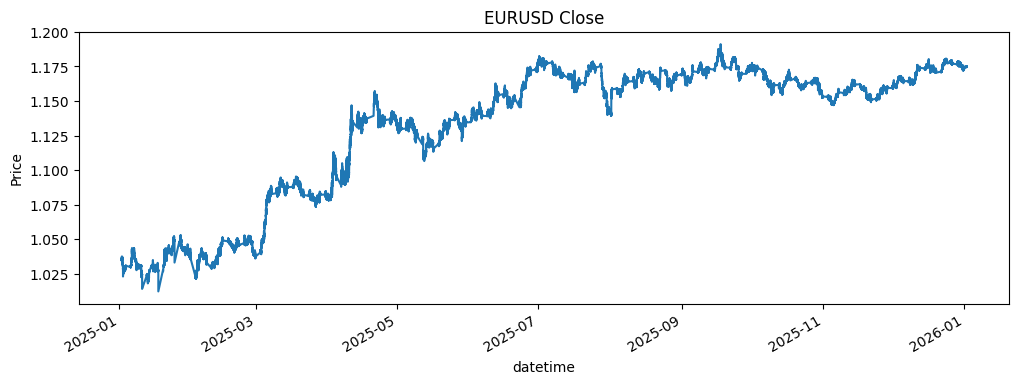

In [14]:
import matplotlib.pyplot as plt
ax = df["close"].plot(figsize=(12, 4), title=f"{TICKER} Close")
ax.set_ylabel("Price")